### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
import random

### Get Data

In [2]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')

# New Timeseries that is the aggregate of the sales for all products and all items in a month
ts_monthly = pd.Series(data = train.groupby([train.date.dt.year, train.date.dt.month])['sales'].sum().values)

#### Create Train, Validation and Test Sets

<ol>
    <li>We divide the timeseries into three parts, 60% train subset, 20% validation subset and 20% test subset.
</ol>

In [5]:
train_idx = np.int(0.6*len(ts_monthly))
val_idx = np.int(0.8*len(ts_monthly))

#### Set up the Configuration Grid Search

In [6]:
# Configuration options for the model()
trend = ['add', 'mul', None]
damped = [True, False]
seasonal = ['add', 'mul', None]
seasonal_periods = [12]

# Configuration options for model.fit()
smoothing_level = [0.2, 0.4, 0.6, 0.8, 1.0]
smoothing_slope = [0.2, 0.4, 0.6, 0.8, 1.0]
smoothing_seasonal = [0.2, 0.4, 0.6, 0.8, 1.0]
damping_slope = [0.2, 0.4, 0.6, 0.8, 1.0]
box_cox = [True, False]
remove_bias = [True, False]

<ol>
    <li>For each possible model config, we create a Holt-Winters model for the train subset.
    <li>For each Holt-Winters model, we fit the model to the train subset using each of the fit configs.
    <li>For each of the fitted models, we predict the likely sales values for the validation set and then calcualte the SMAPE score for the predictions.
    <li>We are looking for the model with the lowest SMAPE score
</ol>        

In [7]:
model_configs = itertools.product(trend, damped, seasonal, seasonal_periods)
fit_configs = itertools.product(smoothing_level, smoothing_slope, smoothing_seasonal, damping_slope, 
                                box_cox, remove_bias)
best_smape = 100
history = np.array(ts_monthly[:train_idx])
for m_config in model_configs:
    t, d, s, s_p = m_config
    try:
        model = ExponentialSmoothing(history, trend = t, damped = d, seasonal = s, seasonal_periods = s_p)
        for f_config in fit_configs:
            sl, ss, s_s, d_s, b, r = f_config
            fit = model.fit(smoothing_level = sl, smoothing_slope = ss, smoothing_seasonal = s_s, 
                            damping_slope = d_s, optimized = False, use_boxcox = b, remove_bias = r)
            preds = fit.predict(train_idx, val_idx-1)
            acts = ts_monthly[train_idx:val_idx]
            smape = np.mean(abs(acts - preds)/(abs(acts) + abs(preds)))*100
            if smape < best_smape:
                best_smape = smape
                best_m_config = m_config
                best_f_config = f_config
    except:
        print("Failed to build a model for config {}".format(m_config))
        continue

print("The lowest SMAPE score achieved for the validation set = %.4f" % best_smape)
print("The parameters for the model with best SMAPE:")
print("trend = %s, damped = %s, seasonal = %s, seasonal_periods = %i" % best_m_config)
print("smoothing_level = %.2f, smoothing_slope = %.2f, smoothing_seasonal = %.2f, damping_slope = %s, box_cox_transformation = %s, remove_bias = %s" 
      % best_f_config)

Failed to build a model for config (None, True, 'add', 12)
Failed to build a model for config (None, True, 'mul', 12)
Failed to build a model for config (None, True, None, 12)
The lowest SMAPE score achieved for the validation set = 0.7771
The parameters for the model with best SMAPE:
trend = add, damped = True, seasonal = add, seasonal_periods = 12
smoothing_level = 0.20, smoothing_slope = 0.20, smoothing_seasonal = 0.60, damping_slope = 1.0, box_cox_transformation = False, remove_bias = False


#### Observations
We look to get a more fine grained estimate of the <i>fit configuration</i> parameters by searching in a range close to the ideal values identified in the earlier step.

In [13]:
# Configuration options for model()
t, d, s, s_p = best_m_config

# Configuration options for model.fit()
smoothing_level = [0.1, 0.15, 0.2, 0.25, 0.3]
smoothing_slope = [0.1, 0.15, 0.2, 0.25, 0.3]
smoothing_seasonal = [0.5, 0.55, 0.6, 0.65, 0.7]
damping_slope = [0.9, 0.95, 1]
box_cox = [False]
remove_bias = [False]

In [14]:
fit_configs = itertools.product(smoothing_level, smoothing_slope, smoothing_seasonal, damping_slope, 
                                box_cox, remove_bias)
best_smape = 100
model = ExponentialSmoothing(history, trend = t, damped = d, seasonal = s, seasonal_periods = s_p)
for f_config in fit_configs:
    sl, ss, s_s, d_s, b, r = f_config
    try:
        fit = model.fit(smoothing_level = sl, smoothing_slope = ss, smoothing_seasonal = s_s, 
                            damping_slope = d_s, optimized = False, use_boxcox = b, remove_bias = r)
        preds = fit.predict(train_idx, val_idx-1)
        acts = ts_monthly[train_idx:val_idx]
        smape = np.mean(abs(acts - preds)/(abs(acts) + abs(preds)))*100
        if smape < best_smape:
            best_smape = smape
            best_f_config = f_config
    except:
        print("Failed to build a model for config {}".format(f_config))
        continue

print("The lowest SMAPE score achieved for the validation set = %.4f" % best_smape)
print("The parameters for the model with best SMAPE:")
print("trend = %s, damped = %s, seasonal = %s, seasonal_periods = %i" % best_m_config)
print("smoothing_level = %.2f, smoothing_slope = %.2f, smoothing_seasonal = %.2f, damping_slope = %s, box_cox_transformation = %s, remove_bias = %s" 
      % best_f_config)

The lowest SMAPE score achieved for the validation set = 0.4046
The parameters for the model with best SMAPE:
trend = add, damped = True, seasonal = add, seasonal_periods = 12
smoothing_level = 0.15, smoothing_slope = 0.30, smoothing_seasonal = 0.70, damping_slope = 0.95, box_cox_transformation = False, remove_bias = False


#### Observations
<ul>
    <li>We now fit the model to the fine-grained values of the fit configuration parameters and get the predictions for the validation set. 
    <li>We plot the actual and predicted values for the validation set to visually understand the quality of the fit.
</ul>

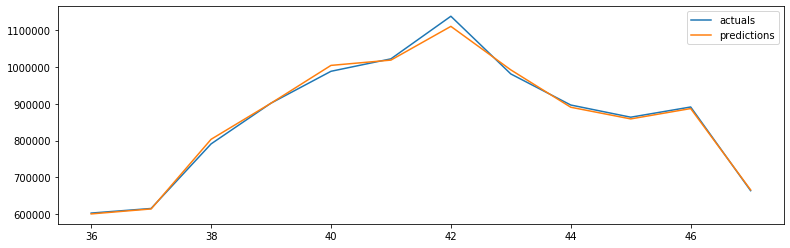

In [15]:
sl, ss, s_s, d_s, b, r = best_f_config
fit = model.fit(smoothing_level = sl, smoothing_slope = ss, smoothing_seasonal = s_s, damping_slope = d_s, 
                optimized = False, use_boxcox = b, remove_bias = r)
preds = fit.predict(train_idx, val_idx-1)
acts = ts_monthly[train_idx:val_idx]

plt.figure(figsize = (13, 4))
plt.plot(ts_monthly.index[train_idx:val_idx], acts, label = 'actuals')
plt.plot(ts_monthly.index[train_idx:val_idx], preds, label = 'predictions')
plt.legend()
plt.show()

#### Observations
We have a good set of cross validated parameter values. We use these to build a new model that includes both the train and validation subsets and use the resulting model to estimate the likely test set error using the test subset. 

The estimated test set SMAPE = 1.0860


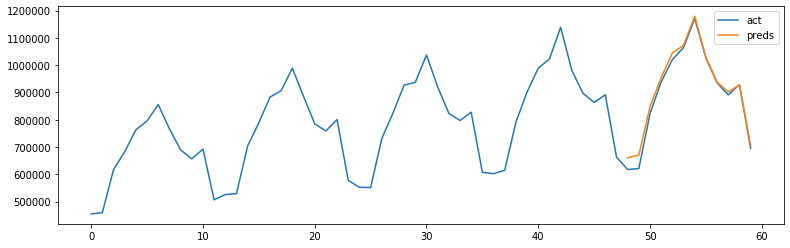

In [16]:
history = np.array(ts_monthly[:val_idx])

model = ExponentialSmoothing(history, trend = t, damped = d, seasonal = s, seasonal_periods = s_p)
fit =  model.fit(smoothing_level = sl, smoothing_slope = ss, smoothing_seasonal = s_s, damping_slope = d_s, 
                optimized = False, use_boxcox = b, remove_bias = r)
preds = fit.predict(val_idx, len(ts_monthly)-1)
acts = ts_monthly[val_idx:]
smape = np.mean(abs(acts - preds)/(abs(acts) + abs(preds)))*100

print("The estimated test set SMAPE = %.4f" % smape)

plt.figure(figsize = (13, 4))
plt.plot(ts_monthly.index, ts_monthly, label = 'act')
plt.plot(ts_monthly.index[val_idx:], preds, label = 'preds')
plt.legend()
plt.show()

### Conclusion
<ul>
    <li>The Holt-Winter's Exponential Smoothening method delivers an estimated test set SMAPE of 1.0860.
    <li>From the plot it is clear that the model does an excellent job of predicting future values for the monthly timeseries.